In [2]:
import json
import altair as alt
import plotly.graph_objects as go
import plotly.subplots as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import express as px
from scipy import stats
from scipy.stats import pointbiserialr, mannwhitneyu
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelEncoder
pd.options.mode.chained_assignment = None

df=pd.read_csv('final_stats.csv')

In [3]:
alt.themes.enable('default')

with open('dark_theme.json', 'r') as file:
    dark_theme = json.load(file)

def my_theme():
    dark_theme_config = {
    "config": {
        "view": {"fill": "black"},
        "background": "black",
        "axis": {"labelColor": "white", "titleColor": "white"},
        "text": {"color": "white"}
    }
}
    return dark_theme_config

alt.themes.register('my_theme', my_theme)
alt.themes.enable('my_theme')

ThemeRegistry.enable('my_theme')

In [4]:
def att_vs_winrate(df, target_col, target_col2):

    color_map = {'str': 'red', 'int': 'blue', 'agi': 'green', 'all': 'purple'}
    df['Color'] = df[target_col2].map(color_map)

    fig = px.box(df, y=target_col, points='all', title=f'Heroes by {target_col2} vs {target_col}.',
                 hover_data=['Name', target_col],
                 color='Primary Attribute', color_discrete_map=color_map)
    
    fig.update_layout(template='plotly_dark', yaxis_title=target_col)

    fig.update_traces(hovertemplate='Name: %{customdata[0]} <br>Divine Win Rate: %{y}')

    fig.show()

att_vs_winrate (df, 'Divine Win Rate', 'Primary Attribute')

In [5]:
def win_rate_picks_correlation(df, target_col, target_col2):
    correlation = df[target_col].corr(df[target_col2])

    fig = px.scatter(df, x=target_col, y=target_col2,
                     labels = {target_col: target_col, target_col2: target_col2},
                     title=f'Win Rate vs. Pick Rate ({target_col}) - Correlation: {correlation:.2f}',
                     template='plotly_dark',
                     color='Primary Attribute',
                     color_discrete_map={'str': 'red', 'int': 'blue', 'agi': 'green', 'all': 'purple'},
                     hover_data=['Name'],
                     size='Divine Wins', size_max=30)

    fig.update_layout(xaxis_title='Divine Picks', yaxis_title='Divine Win Rate')
    
    fig.update_traces(hovertemplate='Name: %{customdata[0]} <br>Divine Picks: %{x} <br>Divine Win Rate: %{y}')
    
    fig.show()

win_rate_picks_correlation(df, 'Divine Picks', 'Divine Win Rate')

In [6]:
top_10_df = df.groupby(['Primary Attribute']).apply(lambda x: x.nlargest(10, 'Divine Win Rate')).reset_index(drop=True)
top_10_df = top_10_df.sort_values(by=['Primary Attribute', 'Divine Win Rate'], ascending=[True, False])

chart = alt.Chart(top_10_df).mark_bar().encode(

    alt.X('Divine Win Rate:Q', title='Divine Win Rate'),
    alt.Y('Name:N', title='Hero', sort=alt.EncodingSortField(field='Primary Attribute')),
    
    color=alt.Color('Primary Attribute:N',
                    scale=alt.Scale(domain=['str', 'int', 'agi', 'all'], range=['red', 'blue', 'green', 'purple']),
                    legend=None),

).properties(
    width=600,
    height=400,
    title='Top 10 Heroes Win Rate in Each Primary Attribute (Grouped Bar Chart)'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16
)

chart

alt.Chart(...)

In [7]:
def type_corr_winrate(df, target_col, feature_col1, feature_col2):
    
    color_map = {'str': 'red', 'int': 'blue', 'agi': 'green', 'all': 'purple'}
    df['Color'] = df[feature_col1].map(color_map)
    fig = px.box(df, x=feature_col2, y=target_col, points='all', title=f'{feature_col2}, {target_col} Correlation.',
                 hover_data=['Name', target_col],
                 color=feature_col1, color_discrete_map=color_map)
    
    fig.update_layout(template='plotly_dark', yaxis_title=target_col)

    fig.update_traces(hovertemplate='Name: %{customdata[0]} <br>Divine Win Rate: %{y}')
    
    fig.show()

type_corr_winrate (df, 'Divine Win Rate', 'Primary Attribute','attack_type')

In [8]:
filtered_df = df[df['attack_type'] != 'int']

label_encoder = LabelEncoder()

df['attack_type_encoded'] = label_encoder.fit_transform(df['attack_type'])

correlation = df['attack_type_encoded'].corr(df['Divine Win Rate'])

print(f"Attack Type, Divine Win Rate Correlation: {correlation}")



Attack Type, Divine Win Rate Correlation: -0.005849717459672492


In [9]:
filtered_df = df[(df['Primary Attribute'] != 'int') & (df['Primary Attribute'] != 'str')]

filtered_df.loc[:, 'attribute_attack_type'] = filtered_df['Primary Attribute'] + '_' + filtered_df['attack_type']

melee_data = filtered_df[filtered_df['attack_type'] == 'Melee'] ['Divine Win Rate']
ranged_data = filtered_df[filtered_df['attack_type'] == 'Ranged'] ['Divine Win Rate']

print(f"Melee data length: {len(melee_data)}")
print(f"Ranged data length: {len(ranged_data)}")

statistic, p_value = mannwhitneyu(melee_data, ranged_data)

alpha = 0.01

print(f"Mann-Whitney U Statistic: {statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between Melee and Ranged heroes.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between Melee and Ranged heroes.")


Melee data length: 30
Ranged data length: 32
Mann-Whitney U Statistic: 478.5
P-value: 0.9887611631235608
Fail to reject the null hypothesis: There is no significant difference between Melee and Ranged heroes.


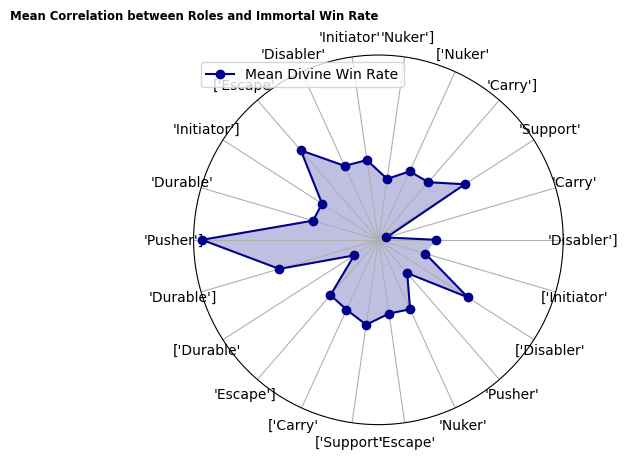

In [10]:
role_win_rates = {}

for _, row in df.iterrows():
    roles = row['roles'].split(', ')
    win_rate = row['Divine Win Rate']

    for role in roles:
        role = role.strip()
        if role not in role_win_rates:
            role_win_rates[role] = {'win_rates': [], 'count': 0}
        role_win_rates[role]['win_rates'].append(win_rate)
        role_win_rates[role]['count'] += 1

unique_roles = list(set(role for role in role_win_rates.keys()))

mean_win_rates = [sum(role_win_rates[role]['win_rates']) / role_win_rates[role]['count']
                  for role in unique_roles]

num_unique_roles = len(unique_roles)

theta = np.linspace(0, 2*np.pi, num_unique_roles, endpoint=False)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])

ax.set_xticks(theta)
ax.set_xticklabels(unique_roles)

ax.plot(theta, mean_win_rates, color='DarkBlue', marker='o', label='Mean Divine Win Rate')
ax.fill(theta, mean_win_rates, facecolor='DarkBlue', alpha=0.25)

ax.set_title('Mean Correlation between Roles and Immortal Win Rate', weight='bold', size='small', position=(0.5, 1.1),
             horizontalalignment='right', verticalalignment='bottom')
ax.legend(loc='upper left')

plt.show()


In [ ]:
# # No Correlation whatsoever between heroes stats and Win Rate in Divine bracket, it's all about player skill level.